# Library Importing

In [74]:
# changes:
# ** Small fixing

import pickle
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt

tqdm.pandas()

# Global Parametres Initialization 

In [75]:
pd.read_csv("/kaggle/input/book-recommendation-dataset/Users.csv").head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [76]:
nrows = 10 ** 5 * 5 
EPOCHS = 50
BATCH_SIZE = 64
MAX_TITLES_FEATURES = 2000
INPUT_PATH = '/kaggle/input/book-recommendation-dataset'
BOOKS_FEATURES = ['Book-Title', 'ISBN']
RATINGS_FEATURES = ['Book-Rating', 'ISBN', 'User-ID']
USERS_FEATURES = ['User-ID', 'Location', 'Age']

In [77]:
books = pd.read_csv(f"{INPUT_PATH}/Books.csv", nrows = nrows)[BOOKS_FEATURES]
rating = pd.read_csv(f"{INPUT_PATH}/Ratings.csv", nrows = nrows)[RATINGS_FEATURES]
users = pd.read_csv(f"{INPUT_PATH}/Users.csv", nrows = nrows)[USERS_FEATURES]

df = books.merge(rating, on='ISBN')
df = df.merge(users, on='User-ID')
df.shape

/tmp/ipykernel_33/3013018640.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(f"{INPUT_PATH}/Books.csv", nrows = nrows)[BOOKS_FEATURES]


(447631, 6)

In [78]:
del books
del rating
del users

# Learing Dataset

In [79]:
df.head()

,Book-Title,ISBN,Book-Rating,User-ID,Location,Age
0,Classical Mythology,0195153448,0,2,"stockton, california, usa",18.0
1,Clara Callan,0002005018,5,8,"timmins, ontario, canada",NaN
2,Decision in Normandy,0060973129,0,8,"timmins, ontario, canada",NaN
3,Flu: The Story of the Great Influenza Pandemic...,0374157065,0,8,"timmins, ontario, canada",NaN
4,The Mummies of Urumchi,0393045218,0,8,"timmins, ontario, canada",NaN


In [80]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1].strip())

In [81]:
def extract_letters(text):
    delete_chars = re.compile(r"[^a-zA-Z]")

    return delete_chars.sub("", text)

df['Location'] = df['Location'].apply(extract_letters)

In [82]:
usa = ['u.a.e', 'u.s. of a.', 'u.s.a.',
'u.s.a>', 'u.s>', 'united sates', 'united staes', 'united state',
'united states', 'united states of america', 'us', 'usa', 'usa & canada',
       'usa (currently living in england)', 'ysa', 'usacurrentlylivinginengland', 
       'usacanada']
df['Location'] = df["Location"].apply(lambda x: 'usa' if x in usa else x)

In [83]:
countries_count = df.groupby(['Location']).agg({'User-ID': 'count'}).sort_values(by='User-ID')

def countries_frequency(name): 
    col = countries_count[countries_count.index == name]
    return col['User-ID'][0]

def sort_countries(name): 
    return 'unknown' if countries_frequency(name) < 10 else name 

df['Location'] = df["Location"].progress_apply(sort_countries)

100%|██████████| 447631/447631 [02:32<00:00, 2934.79it/s]


In [84]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [85]:
df['Book-Rating'] = df['Book-Rating'].apply(lambda x: int(df['Book-Rating'].mean()) if x == 0 else x)

In [86]:
df = df.drop(['ISBN', 'User-ID'], axis=1)

# Data Visualization

Book-Rating
3     273322
8      42280
10     33960
7      30298
9      28805
5      19502
6      14279
4       3364
2       1067
1        754
Name: count, dtype: int64


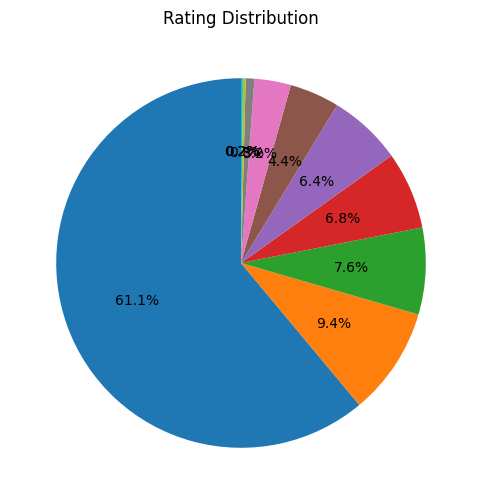

Location
usa               320559
canada             35695
unitedkingdom      15037
germany            11456
na                 11177
                   ...  
solomonislands        10
indonesia             10
framingham            10
bahamas               10
moldova               10
Name: count, Length: 82, dtype: int64


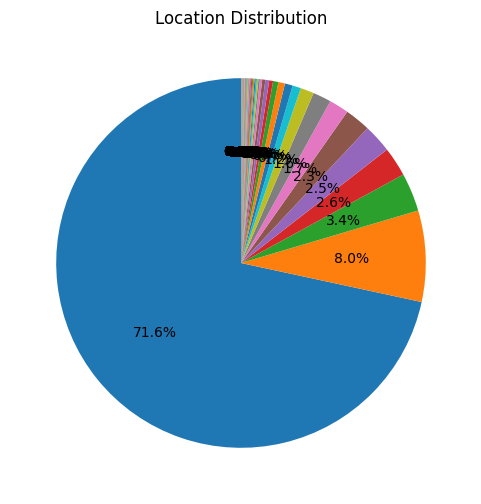

In [87]:
# Count the occurrences of each rating
counts = df['Book-Rating'].value_counts()

# Create a pie chart to visualize the distribution of ratings
plt.figure(figsize=(6, 6))
print(counts)
plt.pie(counts, autopct='%1.1f%%', startangle=90)
plt.title('Rating Distribution')
plt.show()

# Count the occurrences of each rating
counts = df['Location'].value_counts()

# Create a pie chart to visualize the distribution of ratings
plt.figure(figsize=(6, 6))
print(counts)
plt.pie(counts, autopct='%1.1f%%', startangle=90)
plt.title('Location Distribution')
plt.show()

# Preprocess the Dataset

In [88]:
# prepare output for categorial model output 
rating = pd.get_dummies(df['Book-Rating'].apply(lambda x: str(x)), dtype=float)

In [89]:
vectorizer = TfidfVectorizer(use_idf = True, max_features = MAX_TITLES_FEATURES)

Books_Titles = df['Book-Title'].tolist() 
Books_Titles = vectorizer.fit_transform(Books_Titles).toarray()
# vectorizer.get_feature_names_out()

In [90]:
loc_enc = LabelEncoder()
loc = loc_enc.fit_transform(df['Location'])
loc_enc.classes_

array(['', 'andorra', 'antarctica', 'argentina', 'australia', 'austria',
       'bahamas', 'belgium', 'brazil', 'bulgaria', 'burma', 'canada',
       'catalunya', 'channelislands', 'chile', 'china', 'costarica',
       'czechrepublic', 'denmark', 'egypt', 'england', 'espaa',
       'euskalherria', 'faraway', 'finland', 'framingham', 'france',
       'germany', 'greece', 'guernsey', 'hongkong', 'hungary', 'iceland',
       'india', 'indonesia', 'iran', 'iraq', 'ireland', 'israel', 'italy',
       'japan', 'kuwait', 'lachineternelle', 'lithuania', 'luxembourg',
       'malaysia', 'malta', 'mexico', 'moldova', 'na', 'naontheroad',
       'netherlands', 'newzealand', 'norway', 'papuanewguinea',
       'philippines', 'poland', 'portugal', 'qatar', 'romania',
       'saintlucia', 'scotland', 'singapore', 'slovenia',
       'solomonislands', 'southafrica', 'southkorea', 'spain', 'sweden',
       'switzerland', 'taiwan', 'turkey', 'unitedkindgonm',
       'unitedkingdom', 'unitedstates', 'univ

# Build Dataset for Tensorflow Model

In [91]:
# Dataset Split to Train, Validation, Test Datasets
def split_data (train_test_val_split: list, **kwargs):
    """
        split lists and np.ndarrays to train/ validation/ test 
        
        Parameters:
        
            train_test_val_split: list
                split values for each dataset
                for example: 
                    train_test_val_split = [0.7, 0.9, 1]
                
                train : 0.7
                valid : 0.2
                test  : 0.1
            **kwargs: data to split  
                For Example: 
                        titles = titles_lst, names = names_lst
                    => {'titles' : titles_lst, 'names': names_lst}
                
        Return: 
            splited data from **kwargs 
    """
    train_split: dict = {}
    valid_split: dict = {}
    test_split: dict = {}
        
    for i, v in kwargs.items(): 
        if type(v) != np.ndarray: 
            v = np.array(v)
            
        length = v.shape[0]
        ind = lambda x: int(x * length) 
        
        train_split[i] = v[:ind(train_test_val_split[0])]
        valid_split[i] = v[ind(train_test_val_split[0]): ind(train_test_val_split[1])]
        test_split[i] =  v[ind(train_test_val_split[1]): ind(train_test_val_split[2])]

    return train_split, valid_split, test_split

In [92]:
# TF Dataset Build from Train, Validation, Test Parts
def preprocess(data):
    data['age'] = tf.reshape(data['age'], (1,))
    return data 
def build_tf_dataset(data): 
    """
        Parameters: 
            data: dict (recomended)
            Data to make tf.Dataset
        Return: 
            tf.Dataset from data
    """
    dataset = (tf.data.Dataset.from_tensor_slices(data)
              .map(preprocess)
              .batch(BATCH_SIZE))
    return dataset 

In [93]:
# split data
train, valid, test = split_data([0.7, 0.9, 1], 
                                # data to split 
                                title = Books_Titles, 
                                location = loc, 
                                age = df["Age"].tolist(), 
                                rating = rating.values
                                )
# build tf datasets
train_dataset = build_tf_dataset(train)
valid_dataset = build_tf_dataset(valid)
test_dataset = build_tf_dataset(test)

# Model Building

In [94]:
# clean memory from useless parameters
del df, train, valid, test

In [95]:
class RecomModel(tf.keras.Model): 
    def __init__(self, loc_dim, titles_shape, output_shape):
        super().__init__()
        self.loc_emb = tf.keras.layers.Embedding(input_dim = loc_dim, output_dim = 10)
        self.hidden_layer = tf.keras.layers.Dense(units = 64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units = output_shape, activation ='softmax')
        self.b_norm = tf.keras.layers.BatchNormalization()
        self.dr_t = tf.keras.layers.Dropout(rate=0.3)
        
    def call(self, batch_data):
        title, loc, age = batch_data['title'], batch_data['location'], batch_data['age'] 
        
        emb_loc = self.loc_emb(loc)
        combined = tf.concat([title, emb_loc, age], axis=1)
        combined = self.b_norm(combined)
        combined = self.dr_t(combined)
        combined = self.hidden_layer(combined)
        output = self.output_layer(combined)
        return output

In [96]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# decay_steps = 100000
# initial_learning_rate = 0.1
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)

loss_obj = CategoricalCrossentropy(
    from_logits=False
)
optimizer_obj = Adam(lr = 1e-4)

In [97]:
# Define the training loop
def loss_fn(y, y_): 
    global loss_obj
    
    return loss_obj(y_true = y, y_pred = y_)

@tf.function
def train_step(model, x, y):
    global optimizer_obj
    
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss = loss_fn(y, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_obj.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Define the validation loop
@tf.function
def val_step(model, x, y):
    logits = model(x, training=False)
    loss = loss_fn(y, logits)
    return loss

In [98]:
class CustomEarlyStopping():
    def __init__(self, model, patience=5, restore_best_weights=True):
#         super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.model = model

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, current):
        if current is None:
            return

        if current < self.best:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
            return False
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.model.set_weights(self.best_weights)
                print('Early stopping')
                return True

# Training Process

In [99]:
loc_dim = loc_enc.classes_.shape[0]
titles_shape = vectorizer.get_feature_names_out().shape[0]
outp_shape = rating.shape[-1]

model = RecomModel(loc_dim, titles_shape, outp_shape)
early_stopping = CustomEarlyStopping(model, patience = 20)

In [100]:
# Train the model

train_loss: list = []
validation_loss: list = []
early_stopping.on_train_begin()
for epoch in range(EPOCHS):
    for tr_batch in tqdm(train_dataset):
        
        y = tr_batch.pop('rating', None)

        x = tr_batch
        # remove 'rating' from x
                
        train_loss_value = train_step(model, x, y)
        
    train_loss.append(train_loss_value)
        
    for vl_batch in valid_dataset:
        
        y = vl_batch.pop('rating', None)

        x = vl_batch
        # remove 'rating' from x
            
        val_loss_value = val_step(model, x, y)
    
    if early_stopping.on_epoch_end(epoch, val_loss_value): 
        break
        
    validation_loss.append(val_loss_value)
    
    print("Epoch {:}: Train Loss: {:.4f}, Validation Loss: {:.4f}"
          .format(  epoch + 1,
                    train_loss[-1].numpy(),
                    validation_loss[-1].numpy()))

100%|██████████| 4896/4896 [01:02<00:00, 78.84it/s] 


Epoch 1: Train Loss: 0.5767, Validation Loss: 2.1685


100%|██████████| 4896/4896 [00:50<00:00, 97.49it/s] 


Epoch 2: Train Loss: 0.5925, Validation Loss: 2.2241


100%|██████████| 4896/4896 [01:21<00:00, 59.77it/s] 


Epoch 3: Train Loss: 0.6020, Validation Loss: 2.2517


100%|██████████| 4896/4896 [00:53<00:00, 92.09it/s] 


Epoch 4: Train Loss: 0.6022, Validation Loss: 2.3322


100%|██████████| 4896/4896 [00:48<00:00, 101.03it/s]


Epoch 5: Train Loss: 0.6170, Validation Loss: 2.3853


100%|██████████| 4896/4896 [00:48<00:00, 100.82it/s]


Epoch 6: Train Loss: 0.6152, Validation Loss: 2.4254


100%|██████████| 4896/4896 [00:47<00:00, 103.91it/s]


Epoch 7: Train Loss: 0.6126, Validation Loss: 2.3367


100%|██████████| 4896/4896 [00:48<00:00, 101.85it/s]


Epoch 8: Train Loss: 0.5702, Validation Loss: 2.4722


100%|██████████| 4896/4896 [00:48<00:00, 101.98it/s]


Epoch 9: Train Loss: 0.5722, Validation Loss: 2.5232


100%|██████████| 4896/4896 [01:21<00:00, 59.77it/s] 


Epoch 10: Train Loss: 0.5427, Validation Loss: 2.8056


100%|██████████| 4896/4896 [01:21<00:00, 59.76it/s] 


Epoch 11: Train Loss: 0.5529, Validation Loss: 2.6388


100%|██████████| 4896/4896 [00:48<00:00, 100.96it/s]


Epoch 12: Train Loss: 0.5483, Validation Loss: 2.7150


100%|██████████| 4896/4896 [00:48<00:00, 101.34it/s]


Epoch 13: Train Loss: 0.5041, Validation Loss: 2.6995


100%|██████████| 4896/4896 [00:49<00:00, 99.67it/s] 


Epoch 14: Train Loss: 0.5358, Validation Loss: 2.8610


100%|██████████| 4896/4896 [01:21<00:00, 59.77it/s] 


Epoch 15: Train Loss: 0.5017, Validation Loss: 2.9411


100%|██████████| 4896/4896 [00:50<00:00, 96.55it/s] 


Epoch 16: Train Loss: 0.5162, Validation Loss: 2.7681


100%|██████████| 4896/4896 [01:21<00:00, 59.77it/s] 


Epoch 17: Train Loss: 0.5342, Validation Loss: 2.8724


100%|██████████| 4896/4896 [00:49<00:00, 99.12it/s] 


Epoch 18: Train Loss: 0.5550, Validation Loss: 2.8892


100%|██████████| 4896/4896 [00:48<00:00, 100.53it/s]


Epoch 19: Train Loss: 0.5179, Validation Loss: 2.8213


100%|██████████| 4896/4896 [00:47<00:00, 102.70it/s]


Epoch 20: Train Loss: 0.5108, Validation Loss: 2.9142


100%|██████████| 4896/4896 [00:47<00:00, 102.05it/s]


Early stopping


In [101]:
def visualize_history(hist, title = 'Training Loss'): 
    # Create a line plot
    plt.plot(hist, label=f'{title}')
    # Add a title and labels
    plt.title(f'{title} History')
    plt.xlabel('Steps')
    plt.ylabel('Loss')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

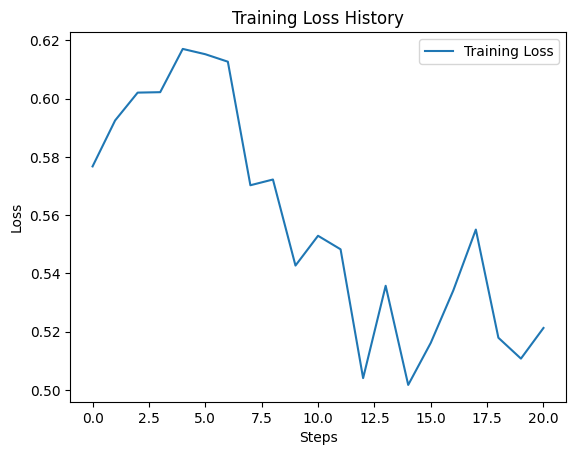

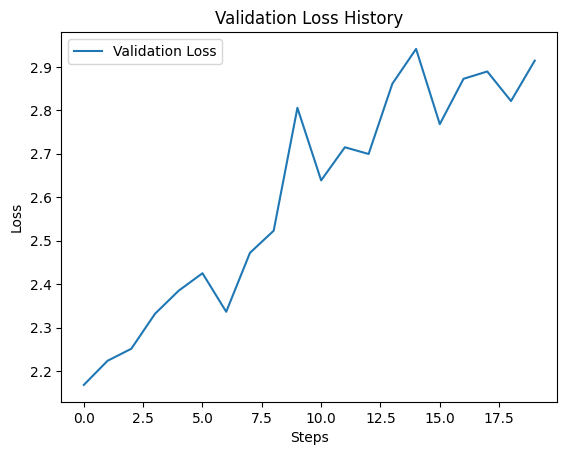

In [102]:
# Create a line plot
visualize_history(train_loss, title='Training Loss')
visualize_history(validation_loss, title='Validation Loss')

# Taking Test Score

tf.Tensor(1.9064652, shape=(), dtype=float32)


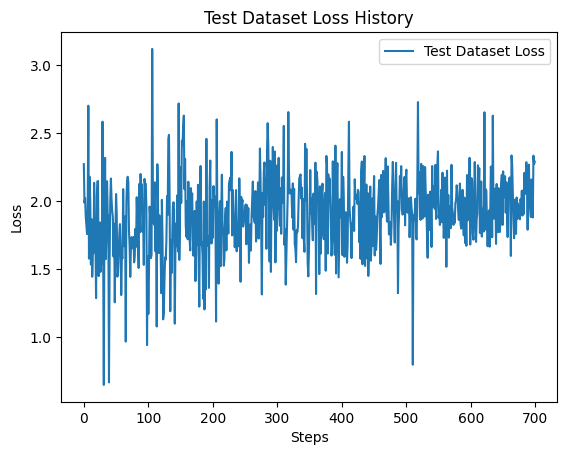

In [103]:
test_loss: list = []
for test_batch in test_dataset: 
    y_true = test_batch.pop('rating', None)
    y_pred = model(test_batch)
    
    loss = loss_fn(y_true, y_pred)
    
    test_loss.append(loss)
    
# check out the loss
print(sum(test_loss)/len(test_loss))
visualize_history(test_loss, title='Test Dataset Loss')

# Save Model, Encoder, Vectorizer for using in future

In [104]:
pickle.dump(vectorizer, open("titles_vectorizer.pickle", "wb"))
pickle.dump(loc_enc, open("location_encoder.pickle", "wb"))
model.save(save_format="tf", filepath = 'recomendation_model')
print('Saved Succesfully')

Saved Succesfully
